In [18]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import make_country_mask
import xarray as xr
import numpy as np
import clustering_sklearn as cl
import utils
import plotting
path_obs_data = '~/data/volume_2/observational/'
filename = 'chrips_tp_1981-2021_africa_aggregated_intervals.nc'
filename = 'chrips_precip_1981-2021.nc'
path_tp = os.path.join(path_obs_data, 'raw', filename)

Open dataset, align format, select OND months 

In [22]:
ds = xr.open_dataarray(path_tp)
ds = ds.resample(time='1M', skipna=True, closed='right',
                 label='right', restore_coord_dims=False
                 ).mean().dropna(dim='time', how='all')

dtfirst = [s+'-01' for s in ds["time"].dt.strftime('%Y-%m').values]
tp = ds.assign_coords({'time':pd.to_datetime(dtfirst)})


<xarray.DataArray 'precip' (time: 492, latitude: 320, longitude: 300)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.5323445 ,
         0.5042815 , 0.6968325 ],
        [       nan,        nan,        nan, ..., 0.46272892,
         0.66016704, 0.7068714 ],
        [       nan,        nan,        nan, ..., 0.54207414,
         0.6513149 , 0.71075463]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.23498605,
         0.21283798, 0.26154986],
        [       nan,        nan,        nan, ..., 0.21711013,
         0.23739026, 0.28548717],
        [       nan,        nan,        nan, ..., 0.19760527,
         0.22979383, 0.24975412]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.38272145,
         0.37711298, 0.45941502],
        [       nan,        nan,        nan, ..., 0.41445225,
         0.4673002 , 0.48118868],
        [       nan,        nan,        nan, ..., 0.46908623,
         0.5328836 , 0.58064145]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -19.88 -19.62 -19.38 ... 54.38 54.62 54.88
  * latitude   (latitude) float64 -39.88 -39.62 -39.38 ... 39.38 39.62 39.88
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-12-01

Get OND months

In [24]:
tp_OND = tp.where(tp.time.dt.month.isin([10,11,12]), drop=True)

In [26]:
mask_xr, df_names = make_country_mask.create_mask(tp_OND[0], level='Countries')

hoa_countries = ['Kenya', 'Ethiopia', 'Uganda', 'Somalia']
df_hoa = df_names[(df_names['abbrev']=='KE') | (df_names['abbrev']=='ET') | \
                  (df_names['abbrev']=='UG') | (df_names['abbrev']=='SO')]
df_hoa

Creating Country Mask:   96000/  96000 (100.0%)


,name,abbrev,label
69,Ethiopia,ET,69
115,Kenya,KE,115
206,Somalia,SO,206
231,Uganda,UG,231


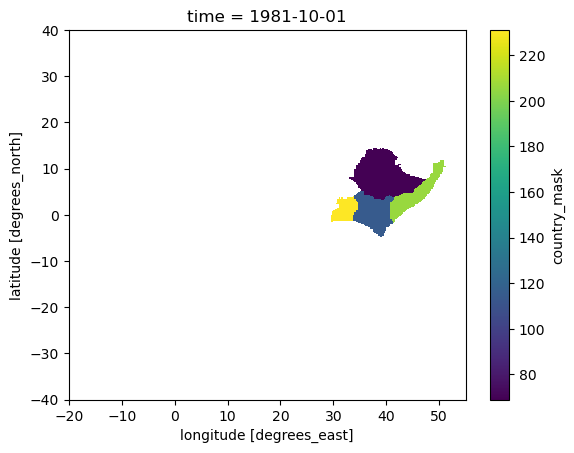

In [27]:
# create a Horn of Africa (hoa) mask
hoa_mask = utils.view_or_replace_labels(mask_xr, regions=df_hoa['label'].values.astype(int))
ax = hoa_mask.plot()


Plotting Corr maps precip, split 0, lag 0


/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


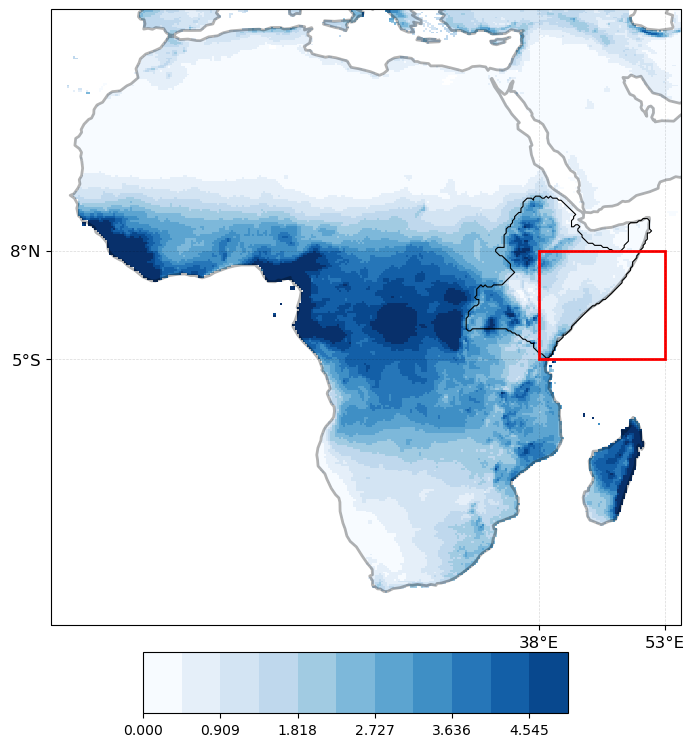

In [53]:
# climatoligical mean of OND rainfall
fg = plotting.plot_maps(tp.mean(dim=('time')), mask_xr=~np.isnan(hoa_mask), x_ticks=np.array(box[:2]), y_ticks=box[2:],
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5, 12))
box = [38, 53, -5, 8]
ax = fg.fig.axes[0]


scale = '50m'
xstep, ystep = 2, 2
cmap=plt.get_cmap('jet',9)#'RdYlBu_r' 'viridis'
proj=plotting.ccrs.PlateCarree(central_longitude=180)
box_top = 2
lon = tp.longitude.values
lat = tp.latitude.values
# Set the starting point of the rectangle 
start_point = (38, -5)
# Draw 
# # #=============================== Start drawing ==============================
# # # select Rectangular area 
RE=Rectangle(start_point,box[1]-box[0],box[3]-box[2],linewidth=2,linestyle='-' ,zorder=2,\
edgecolor='red',facecolor='none', transform=plotting.ccrs.PlateCarree()) #2
ax.add_patch(RE)



In [ ]:
f, axs = plt.subplots(2)
mask_wet_regions.plot(ax=axs[0])
os.chdir('/data/volume_2/observational')
path_mask = 'chirps_hoa_dry_mask_0.25deg_new.nc'
if os.path.isfile(path_mask):
    os.remove(path_mask)
mask_wet_regions.to_netcdf(path_mask, mode='w')
# mask_EC46_res = utils.regrid_xarray(mask_wet_regions, 1.5, periodic=False) # regrid to 1.5 degrees
# mask_EC46_res.plot(ax=axs[1])
# mask_EC46_res.to_netcdf('/data/volume_2/subseasonal/chirps_hoa_dry_mask_1.5deg.nc')
# ds_EC46 = xr.open_dataset('/data/volume_2/subseasonal/ecmwf/forecast/ecmwf-forecast-tp-20200611.nc')['tp']
# ds_EC46lonlat = ds_EC46.isel(forecast_time=0).mean(dim=('realization', 'lead_time'))
# ds_EC46lonlat = utils.get_selbox(ds_EC46lonlat, selbox=(10, 70, -30, 25))
# fg = plotting.plot_maps(ds_EC46lonlat.where(mask_EC46_res.values), 
#                        size=4, cbar_vert=-0.1, cmap=plt.cm.Blues,  clevels=np.linspace(0, 5E-3, 12), zoomregion=(25,55,-6,18))

          Ethiopia     Kenya   Somalia    Uganda
Ethiopia  1.000000  0.190512  0.776527  0.711918
Kenya     0.190512  1.000000  0.548281  0.493686
Somalia   0.776527  0.548281  1.000000  0.670622
Uganda    0.711918  0.493686  0.670622  1.000000


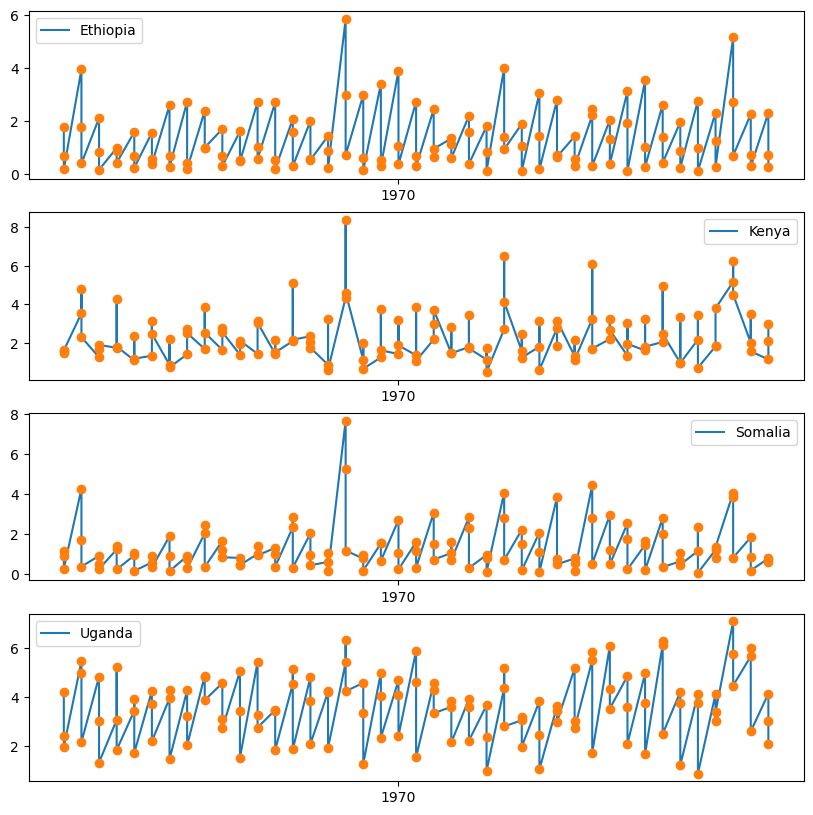

In [33]:
country_labels = np.unique(hoa_mask)[:-1].astype(int)
fig, axes = plt.subplots(len(country_labels), figsize=(10,10))
dfs = []
for i, label in enumerate(country_labels):
    tp_country = tp_hoa_OND.where(hoa_mask.values==label).mean(dim=('latitude', 'longitude'))
    country_name = df_hoa[df_hoa['label'].astype(int)==label]['name'].values[0]
    axes[i].plot(utils.pd.to_datetime(tp_country.time.dt.year.values), tp_country.values, label=country_name)
    axes[i].plot_date(x=utils.pd.to_datetime(tp_country.time.dt.year.values), y=tp_country, label=None)
    axes[i].legend()
    dfs.append(tp_country.to_dataframe(name=country_name))
print(pd.concat(dfs, axis=1).corr())

In [50]:
tp_hoa = tp_OND.where(~np.isnan(hoa_mask))


<xarray.DataArray 'precip' (time: 123, latitude: 320, longitude: 300)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -19.88 -19.62 -19.38 ... 54.38 54.62 54.88
  * latitude   (latitude) float64 -39.88 -39.62 -39.38 ... 39.38 39.62 39.88
  * time       (time) datetime64[ns] 1981-10-01 1981-11-01 ... 2021-12-01

Plotting Corr maps precip, split 0, lag 0


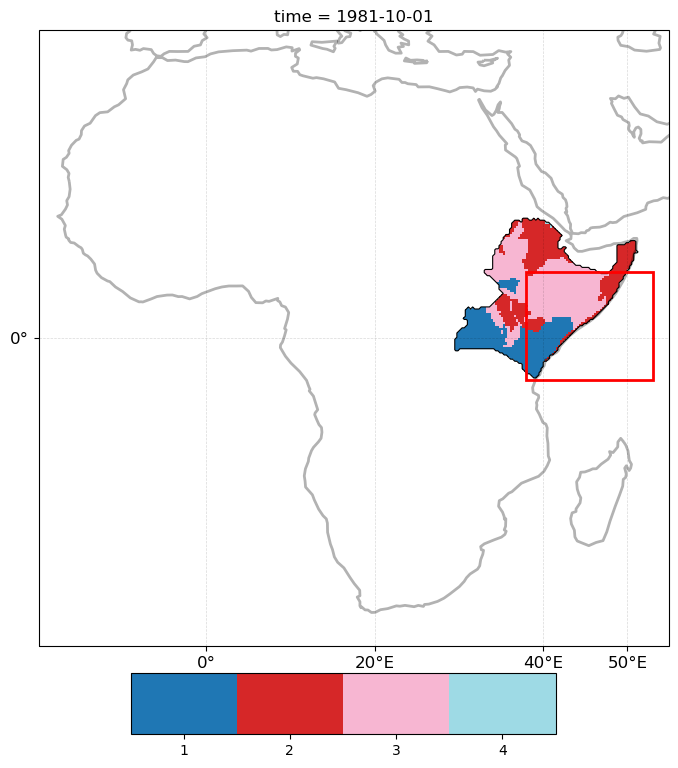

In [63]:
from matplotlib.patches import Rectangle
n_clusters = 4
xrclustered, algorithm = cl.skclustering(tp_hoa, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': n_clusters},
                                         dimension='spatial')

# Set the parameters required by the drawing function 
box = [38, 53, -5, 8]
fg = plotting.plot_labels(xrclustered,   
                     kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )
ax = fg.fig.axes[0]


scale = '50m'
xstep, ystep = 2, 2
cmap=plt.get_cmap('jet',9)#'RdYlBu_r' 'viridis'
proj=plotting.ccrs.PlateCarree(central_longitude=180)
box_top = 2
lon = tp.longitude.values
lat = tp.latitude.values
# Set the starting point of the rectangle 
start_point = (38, -5)
# Draw 
# # #=============================== Start drawing ==============================
# # # select Rectangular area 
RE=Rectangle(start_point,box[1]-box[0],box[3]-box[2],linewidth=2,linestyle='-' ,zorder=2,\
edgecolor='red',facecolor='none', transform=plotting.ccrs.PlateCarree()) #2
ax.add_patch(RE)

In [82]:
from sklearn.metrics import silhouette_score
space_time_vec, output_space_time, indices_mask = cl.create_vector(tp_hoa)
# space_time_vec = space_time_vec[space_time_vec[1]!= -32767, None]

# silhouette_score(space_time_vec, algorithm.labels_)


Plotting Corr maps precip, split 0, cluster 1
Plotting Corr maps precip, split 0, cluster 2


/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


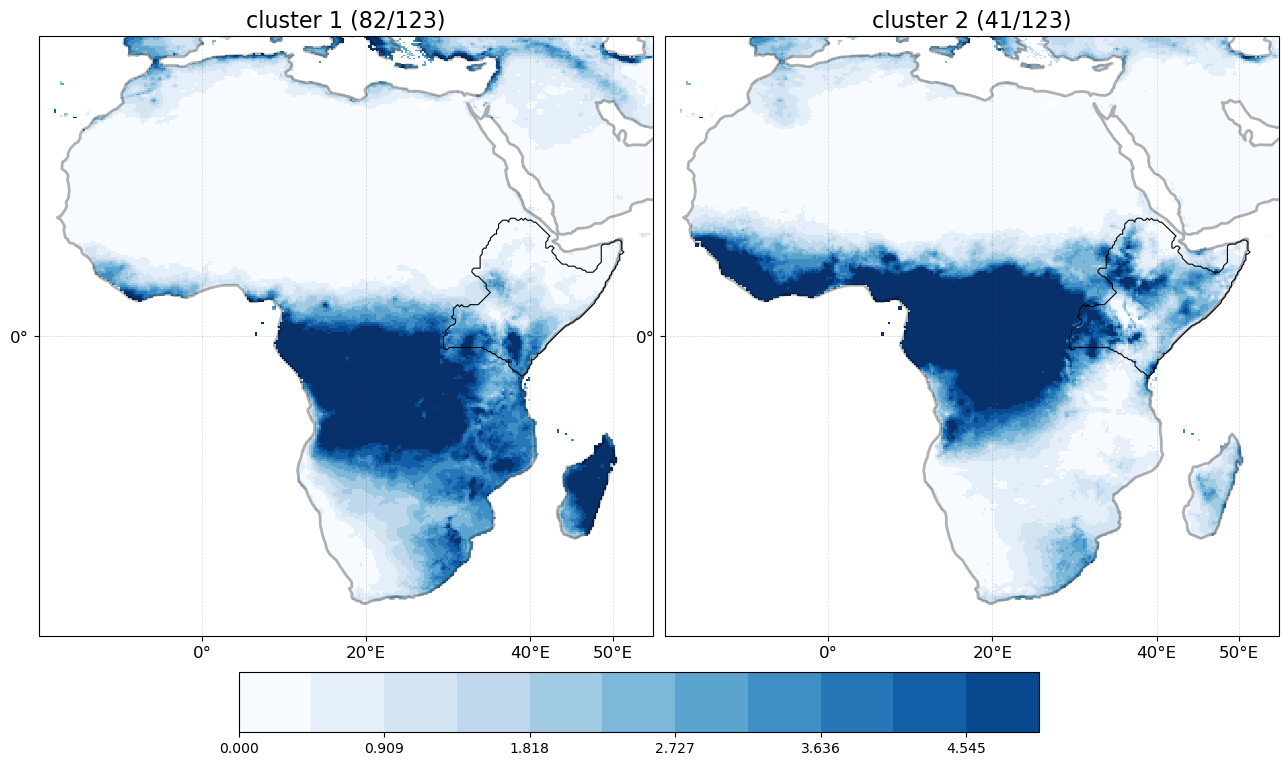

In [37]:
xrclustered, algorithm = cl.skclustering(tp_OND, spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))

plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5, 12),
                   subtitles=[percentages])

In [ ]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(mask_wet_regions), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

In [ ]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

In [ ]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

In [ ]:
tp_hoa_binary = cl.binary_occurences_quantile(tp_hoa, 66)

xrclustered, algorithm = cl.skclustering(tp_hoa_binary, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 3, 'affinity':'jaccard', 'linkage':'complete'},
                                         dimension='spatial')
plotting.plot_labels(xrclustered,   
                   kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )

In [ ]:
df_hoa['label']

In [ ]:
plt.plot_date(x=utils.pd.to_datetime(tp_somalia.time.values), y=tp_somalia)

In [ ]:
df = tp_somalia.to_dataframe(name='tp_somalia')

In [ ]:
df.loc[df.index.month==10].hist() ; df.loc[df.index.month==10].plot()